In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
#statement to check if measurement condition works
for row in session.query(Measurement, Measurement.date).limit(5).all():
    print(row)

(<sqlalchemy.ext.automap.measurement object at 0x1541c9a10>, '2010-01-01')
(<sqlalchemy.ext.automap.measurement object at 0x1541f1810>, '2010-01-02')
(<sqlalchemy.ext.automap.measurement object at 0x1541f1a10>, '2010-01-03')
(<sqlalchemy.ext.automap.measurement object at 0x1541f1a90>, '2010-01-04')
(<sqlalchemy.ext.automap.measurement object at 0x1541f1b10>, '2010-01-06')


In [10]:
#statement to check if station condition works
for row in session.query(Station, Station.name).limit(5).all():
    print(row)

(<sqlalchemy.ext.automap.station object at 0x1541fc450>, 'WAIKIKI 717.2, HI US')
(<sqlalchemy.ext.automap.station object at 0x1541fc690>, 'KANEOHE 838.1, HI US')
(<sqlalchemy.ext.automap.station object at 0x1541fc710>, 'KUALOA RANCH HEADQUARTERS 886.9, HI US')
(<sqlalchemy.ext.automap.station object at 0x1541fc790>, 'PEARL CITY, HI US')
(<sqlalchemy.ext.automap.station object at 0x1541fc810>, 'UPPER WAHIAWA 874.3, HI US')


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
dates_dataset = []
for row in session.query(Measurement.date).all():
    dates_dataset.append(row)

dates_df = pd.DataFrame(dates_dataset)
dates_df.sort_values
print(dates_df.max())

date    2017-08-23
dtype: object


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
cutoff_date = '2016-08-23'

# Perform a query to retrieve the data and precipitation scores
prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > cutoff_date).all()
prcp

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp)
prcp_df

# Sort the dataframe by date
prcp_df.sort_values(by='date')
prcp_df



,date,prcp
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
...,...,...
2218,2017-08-19,0.09
2219,2017-08-20,NaN
2220,2017-08-21,0.56
2221,2017-08-22,0.50


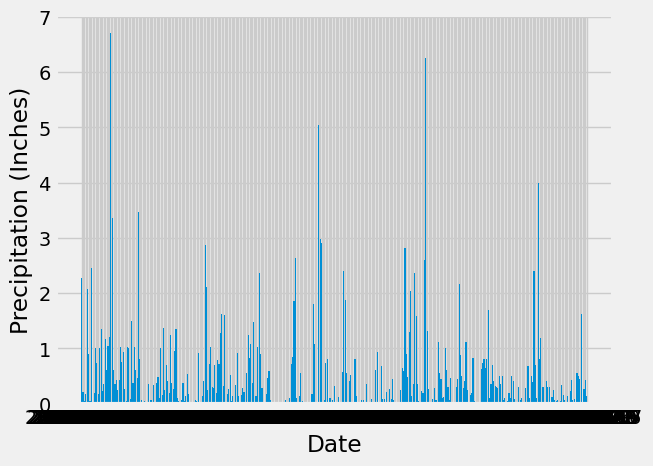

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
x_values = prcp_df['date']
y_values = prcp_df['prcp']
plt.bar(x_values, y_values)
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df['prcp'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(Measurement.station).count()
stations

19550

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station).label('station_count')) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Calculate min, max, and avg temperatures directly in the query
station_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
    .filter(Measurement.station == 'USC00519281') \
    .all()

# Extract the results from the query
min_temp, max_temp, avg_temp = station_temp[0]

print(f"Station USC00519281 min temp: {min_temp}")
print(f"Station USC00519281 max temp: {max_temp}")
print(f"Station USC00519281 avg temp: {avg_temp}")

Station USC00519281 min temp: 54.0
Station USC00519281 max temp: 85.0
Station USC00519281 avg temp: 71.66378066378067


In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date = session.query(func.max(Measurement.date)).scalar()
last_date = datetime.strptime(last_date, '%Y-%m-%d')
cutoff_date_12month = last_date - timedelta(days=365)

# Query the last 12 months of temperature observation data for the station
last_12_months_temps = session.query(Measurement.tobs) \
    .filter(Measurement.station == 'USC00519281') \
    .filter(Measurement.date >= cutoff_date_12month) \
    .all()

# Convert the result to a DataFrame
last_12_months_temps_df = pd.DataFrame(last_12_months_temps, columns=['tobs'])

<Axes: ylabel='Frequency'>

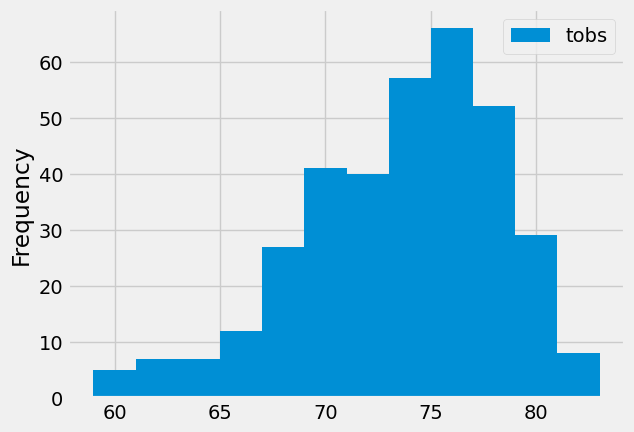

In [19]:
# plot the results as a histogram
last_12_months_temps_df.plot.hist(bins=12)

# Close Session

In [20]:
# Close Session
session.close()